In [1]:
import torch
from models.gspnp.lightning_GSDRUNet import StudentGrad
import math

In [2]:
def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [3]:
device='cuda'

In [4]:
from models.dpirUnet import NNclass2

In [5]:
model=NNclass2(numInChan=3,numOutChan=3).to('cuda')

In [6]:
model.network.load_state_dict(torch.load('miscs/unet.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
from PIL.Image import open as imopen
import numpy as np

In [8]:
XArr=np.asarray(imopen('/export/project/zihao/potential/set3c/butterfly.png'))
X=torch.tensor(XArr,dtype=torch.float32,device='cpu')

In [9]:
X=X.permute(2,0,1).unsqueeze(0)

In [10]:
X.shape

torch.Size([1, 3, 256, 256])

In [11]:
import matplotlib.pyplot as plt

In [12]:
X=(X/255.).to(device)

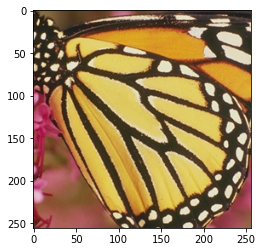

In [13]:
plt.imshow(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [14]:
from scipy import ndimage
from hdf5storage import loadmat
kernels=loadmat('miscs/Levin09.mat')['kernels']
kernel=kernels[0,1]

In [15]:
Xblur=torch.tensor(ndimage.filters.convolve(XArr, np.expand_dims(kernel, axis=2), mode='wrap'),dtype=torch.float32,device=device).permute(2,0,1).unsqueeze(0)+torch.FloatTensor(X.size()).normal_(mean=0, std=7.65/255.).to(X.device)
Xblur=(Xblur/255.).to(device)

/tmp/ipykernel_94599/859837543.py:1: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Xblur=torch.tensor(ndimage.filters.convolve(XArr, np.expand_dims(kernel, axis=2), mode='wrap'),dtype=torch.float32,device=device).permute(2,0,1).unsqueeze(0)


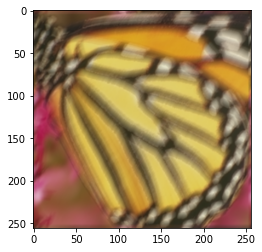

In [16]:
plt.imshow(Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [17]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [18]:
calculate_psnr(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy()*255,Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy()*255)

16.764788312704674

In [19]:
from models.pnp import PNP,DPIRPNP
from models.deqFixedPoint import DEQFixedPoint,nesterov,simpleIter

In [20]:
model=DPIRPNP(1.0,0.9,model,False).to(device)

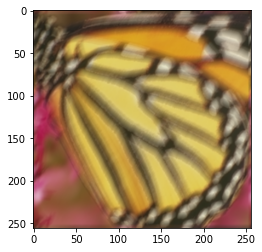

In [21]:
plt.imshow(Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [22]:
model.initialize_prox(Xblur,kernel)

In [23]:
X0=model.calculate_prox(Xblur)

In [26]:
model.train()
Xrecon=nesterov(lambda z:model(z,torch.tensor([0.0],dtype=torch.float32,requires_grad=True).to(device),True),X0.requires_grad_(),X.requires_grad_(),50)
Xrecon=model(Xrecon.requires_grad_(), torch.tensor([0.0],dtype=torch.float32,requires_grad=True).to(device),False)

22.717041644176668
24.21451260269231
25.73071514543888
27.19381501619104
28.55313464344277
29.774476611259068
30.843716293264517
31.76597442188521
32.557891645857914
33.23846176161257
33.823475848225954
34.32463551850197
34.75106795270534
35.11100701025595
35.41245337915566
35.66308136205747
35.869876187841705
36.03891744859554
36.17549444623046
36.28439271723161
36.37005693287636
36.436456488633404
36.4871445280769
36.52511061914822
36.55278760884448
36.572123207645824
36.584689034570296
36.591783576210986
36.594503731368924
36.593781554019
36.59039487526311
36.58496910048553
36.57798295249655
36.569781757047856
36.56059889391298
36.5505823608572
36.539824282120875
36.52838408643969
36.51630896691766
36.50364767735341
36.49045626238984
36.47680062898133
36.46275319864685
36.44838733529909
36.433771897085215
36.41896610601963
36.40401581849758
36.38895154602517
36.37379085521639
36.358540776609885


In [ ]:
plt.imshow(Xrecon[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [ ]:
import utils.utils_sr as utils_sr

In [ ]:

def calculate_F(x,s,img,lamb):
        '''
        Calculation of the objective function value f + lamb*s
        :param x: Point where to evaluate F
        :param s: Precomputed regularization function value
        :param img: Degraded image
        :return: F(x)
        '''

        deg_x = utils_sr.imfilter(x,model.k_tensor[0].flip(1).flip(2).expand(3,-1,-1,-1))
        F = 0.5 * torch.norm(img - deg_x, p=2) ** 2 + lamb * s
        return F.item()

In [ ]:
relative_diff_F_min=1e-6
diff_F=1
F_old=1
maxitr=30
i=0
lamb=0.1
tau=10.0
x=X0
model.initialize_prox(Xblur,kernel)
while i < maxitr and abs(diff_F)/F_old > relative_diff_F_min:
    i+=1
    sigma_denoiser = 13.770

    x_old = x

    #Denoising of x_old and calculation of F_old
    Ds, f = model.rObj.grad2(x_old, sigma_denoiser / 255.)
    Ds = Ds.detach()
    f = f.detach()
    Dx = x_old -   Ds
    s_old = 0.5 * (torch.norm(x_old.double() - f.double(), p=2) ** 2)
    F_old = calculate_F(x_old, s_old, Xblur,lamb)

    backtracking_check = False

    while not backtracking_check:

        # Gradient step
        z = (1 - lamb * tau) * x_old + lamb * tau * Dx

        # Proximal step
        x = model.calculate_prox(z)

        # Calculation of Fnew
        f = model.rObj.grad2(x, sigma_denoiser / 255.)[1]
        f = f.detach()
        s = 0.5 * (torch.norm(x.double() - f.double(), p=2) ** 2)
        F_new = calculate_F(x,s,Xblur,lamb)

        # Backtracking
        diff_x = (torch.norm(x - x_old, p=2) ** 2).item()
        diff_F = F_old - F_new
        if diff_F < (0.1 / tau) * diff_x and abs(diff_F)/F_old > relative_diff_F_min:
            backtracking_check = False
            tau = 0.9 * tau
            x = x_old
        else:
            backtracking_check = True
plt.imshow(x[0,:,:,:].detach().permute(1,2,0).cpu().numpy())
plt.show()

        

        

In [ ]:
calculate_psnr(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy()*255,Xrecon[0,:,:,:].detach().permute(1,2,0).cpu().numpy()*255)

In [ ]:
calculate_psnr(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy()*255,x[0,:,:,:].detach().permute(1,2,0).cpu().numpy()*255)